In [34]:
import pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [35]:
METRICS_DIR = Path("../results/metrics")
PLOTS_DIR = Path("../results/plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)



📊 LOADING DATA
   ✓ Argone
   ✓ Beijing
   ✓ Chengdu
   ✓ Netherland-0
   ✓ Netherland-1
   ✓ Netherland-2

📊 GENERATING GROUPED HORIZON COMPARISON PLOTS

🔹 Processing group: Hourly
   Processing: Argone
   Processing: Beijing
   Processing: Chengdu


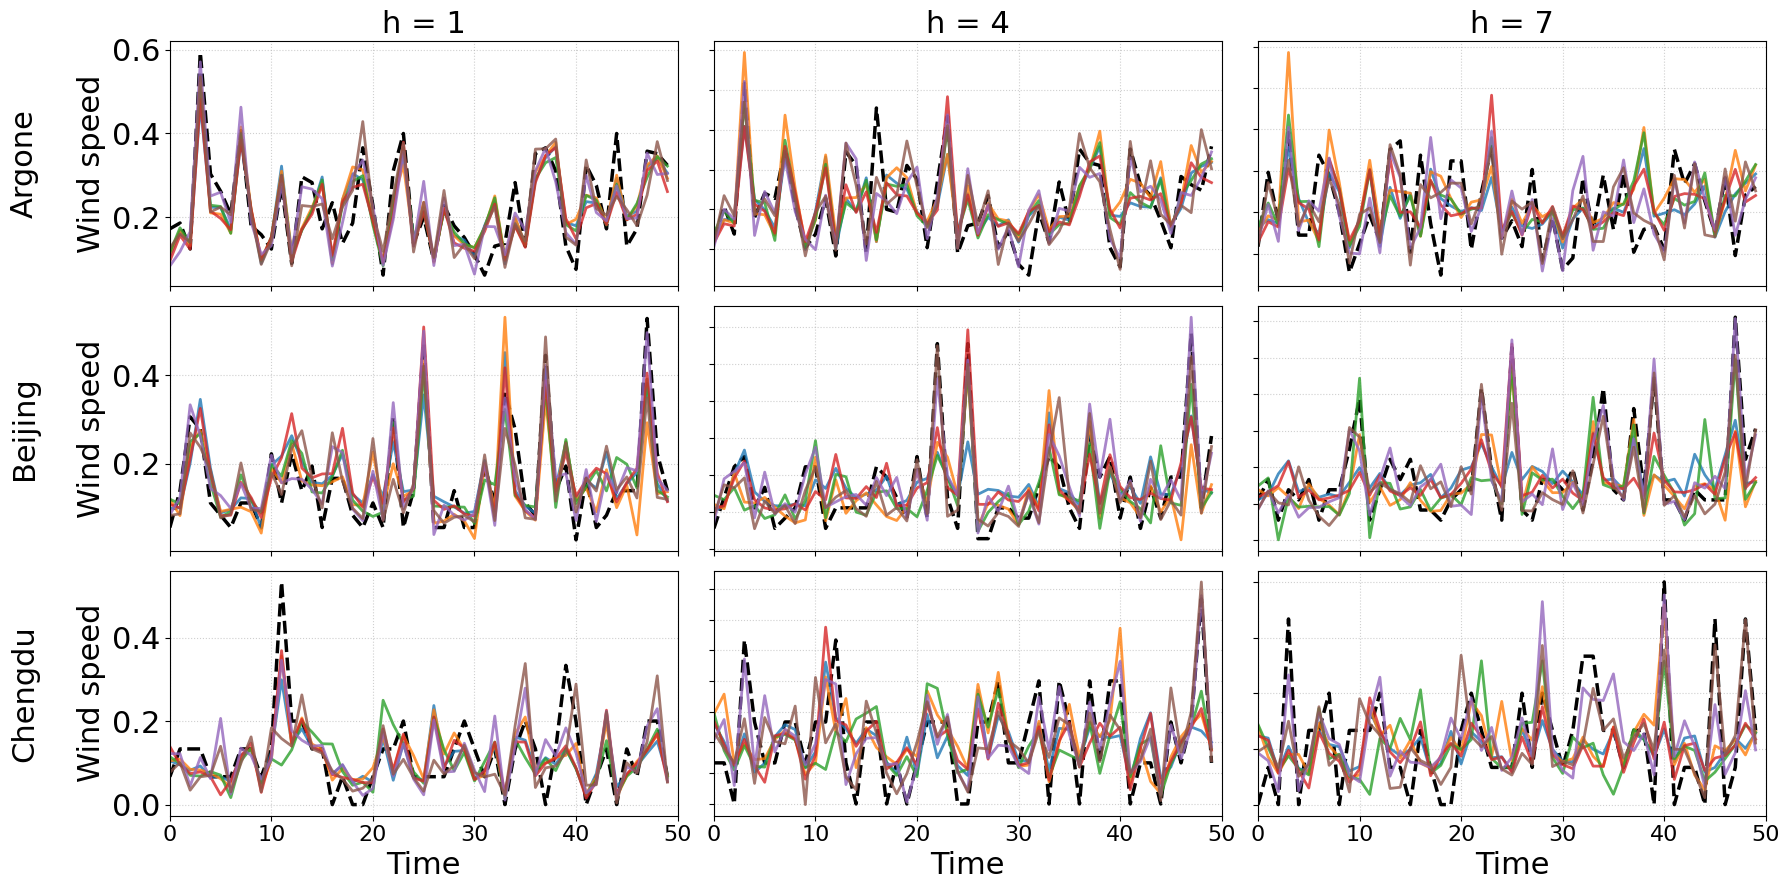

   ✅ Saved: horizon_comparison_group_Hourly.png

🔹 Processing group: Netherland
   Processing: Schiphol
   Processing: De Bilt
   Processing: Leeuwarden


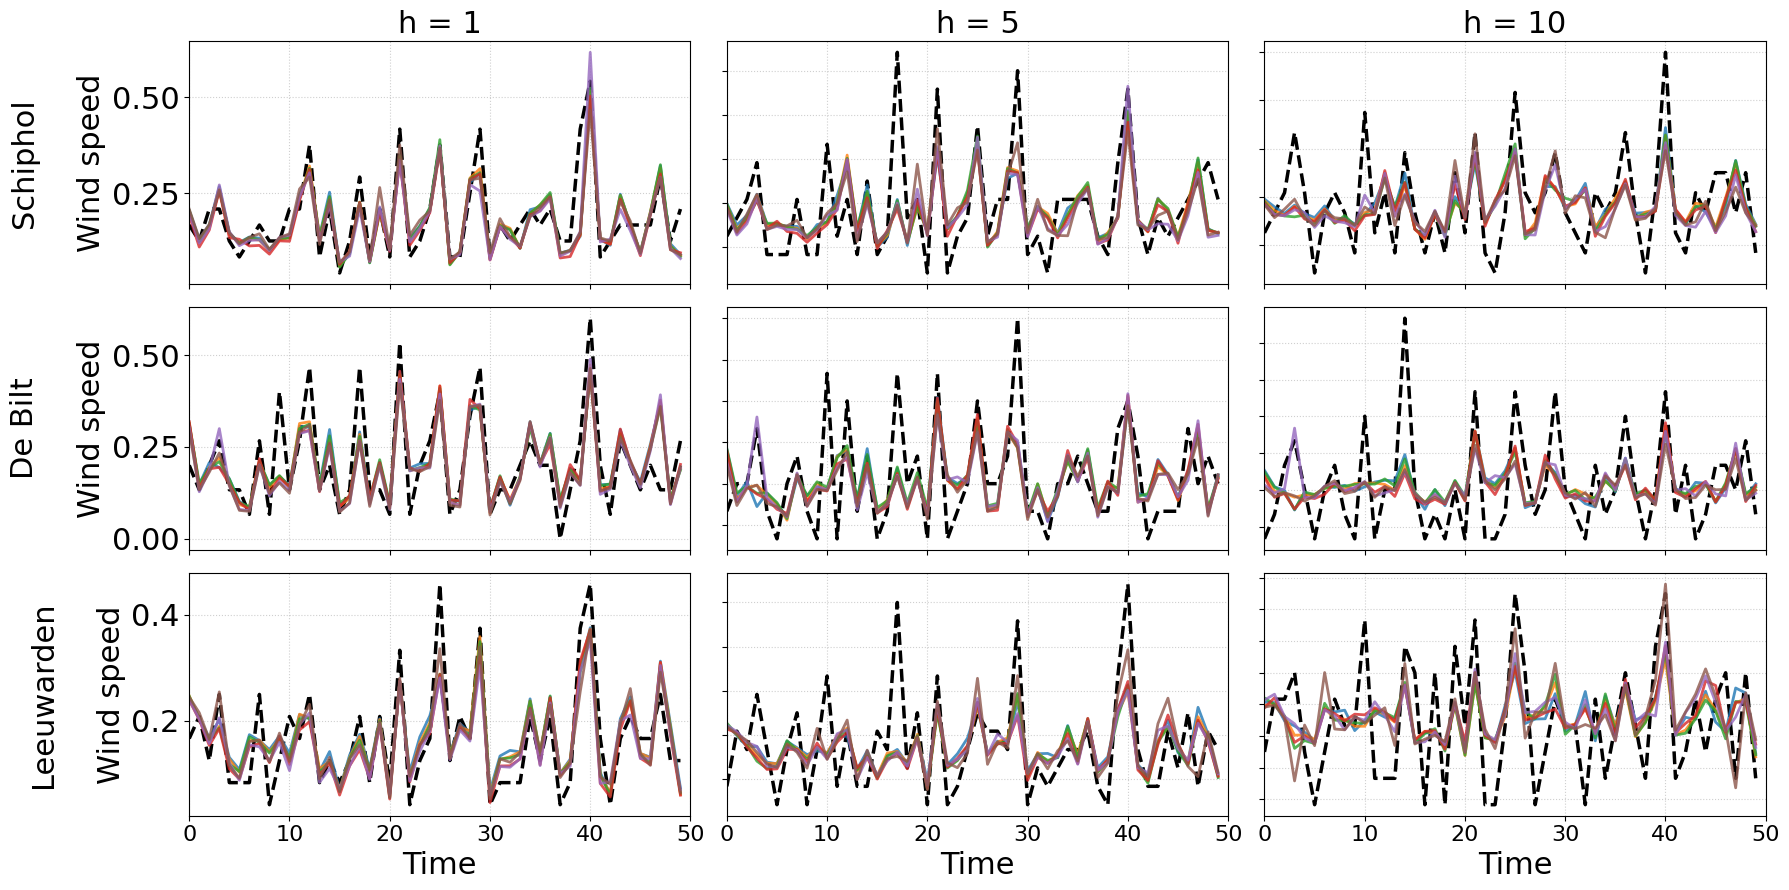

   ✅ Saved: horizon_comparison_group_Netherland.png

✅ All group plots saved to: ../results/plots


In [40]:
# Mapeo de nombres
dataset_display_names = {
    "Netherland-0": "Schiphol",
    "Netherland-1": "De Bilt",
    "Netherland-2": "Leeuwarden",
    "Argone": "Argone",
    "Beijing": "Beijing",
    "Chengdu": "Chengdu"
}

# Definir grupos
groups = {
    "Hourly": ["Argone", "Beijing", "Chengdu"],
    "Netherland": ["Netherland-0", "Netherland-1", "Netherland-2"]
}

# ==========================================
# CARGAR TODOS LOS DATOS
# ==========================================

files = sorted(METRICS_DIR.glob("*.pkl"))
all_data = {}

print("\n" + "="*80)
print("📊 LOADING DATA")
print("="*80)

for file in files:
    dataset_name = file.stem.replace("results_", "")
    
    with open(file, "rb") as f:
        file_content = pickle.load(f)
    
    if "models" in file_content:
        all_data[dataset_name] = file_content
        print(f"   ✓ {dataset_name}")

# ==========================================
# PROCESAR CADA GRUPO
# ==========================================

print("\n" + "="*80)
print("📊 GENERATING GROUPED HORIZON COMPARISON PLOTS")
print("="*80)

for group_name, dataset_list in groups.items():
    
    print(f"\n🔹 Processing group: {group_name}")
    
    # Filtrar solo los datasets que existen
    existing_datasets = [ds for ds in dataset_list if ds in all_data]
    
    if not existing_datasets:
        print(f"   ⚠️  No data found for group {group_name}")
        continue
    
    n_datasets = len(existing_datasets)
    
    # ==========================================
    # CREAR FIGURA CON SUBPLOTS (n_datasets × 3)
    # ==========================================
    
    fig, axes = plt.subplots(n_datasets, 3, figsize=(18, 3 * n_datasets))
    
    # Asegurar que axes sea 2D
    if n_datasets == 1:
        axes = axes.reshape(1, -1)
    
    # Número de puntos a mostrar
    n_points = 50
    
    for row_idx, dataset_name in enumerate(existing_datasets):
        
        file_content = all_data[dataset_name]
        display_name = dataset_display_names.get(dataset_name, dataset_name)
        
        print(f"   Processing: {display_name}")
        
        # Obtener horizonte H
        H = list(file_content["models"].values())[0]["args"]["horizon"]
        
        # Determinar horizontes a plotear
        if H == 7:
            horizons_to_plot = [1, 4, 7]
        elif H == 10:
            horizons_to_plot = [1, 5, 10]
        elif H == 12:
            horizons_to_plot = [1, 6, 12]
        else:
            horizons_to_plot = [1, H // 2, H]
        
        horizon_indices = [h - 1 for h in horizons_to_plot]
        
        # Crear diccionario de pronósticos
        forecast_dict = {
            model_name: (
                model_info["forecast"]["y_true"],
                model_info["forecast"]["y_pred"]
            )
            for model_name, model_info in file_content["models"].items()
        }
        
        # ==========================================
        # PLOTEAR CADA HORIZONTE (COLUMNAS)
        # ==========================================
        
        for col_idx, (h_idx, h_label) in enumerate(zip(horizon_indices, horizons_to_plot)):
            
            ax = axes[row_idx, col_idx]
            target_plotted = False
            
            for model_name, (y_true_data, y_pred_data) in forecast_dict.items():
                
                # Plotear target una sola vez
                if not target_plotted:
                    y_true = y_true_data[0:n_points, h_idx]
                    ax.plot(y_true, label="Target",
                           linestyle='--', color='black', linewidth=2.5)
                    target_plotted = True
                
                # Predicción del modelo
                y_pred = y_pred_data[0:n_points, h_idx]
                model_label = model_name.replace('_', '-')
                ax.plot(y_pred, label=model_label, linewidth=2, alpha=0.8)
            
            # ===== CONFIGURACIÓN DE CADA SUBPLOT =====
            ax.set_xlim(0, n_points)
            
            # Xlabel y valores del eje X solo en la última fila
            if row_idx == n_datasets - 1:
                ax.set_xlabel("Time", fontsize=22)
                ax.tick_params(axis='x', which='major', labelsize=16)
            else:
                ax.set_xticklabels([])  # Ocultar valores del eje X
            
            # Ylabel solo en la primera columna
            if col_idx == 0:
                ax.set_ylabel(f"{display_name}\n\nWind speed", fontsize=22)
                ax.tick_params(axis='y', which='major', labelsize=22)
            else:
                ax.set_yticklabels([])  # Ocultar valores del eje Y
            
            # Título solo en la primera fila
            if row_idx == 0:
                ax.set_title(f"h = {h_label}", fontsize=22)
            
            ax.grid(True, linestyle=':', alpha=0.6)
    
    # ===== AJUSTAR ESPACIADO =====
    plt.tight_layout()
    
    # Guardar
    output_path = PLOTS_DIR / f"horizon_comparison_group_{group_name}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Saved: {output_path.name}")

print("\n" + "="*80)
print(f"✅ All group plots saved to: {PLOTS_DIR}")
print("="*80)


📊 LOADING DATA FROM MULTIPLE SOURCES

📄 Argone
   ✓ RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined: 9 total models

📄 Beijing
   ✓ RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined: 9 total models

📄 Chengdu
   ✓ RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined: 9 total models

📄 Netherland-0
   ✓ RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined: 9 total models

📄 Netherland-1
   ✓ RNN models: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM']
   ✓ Transformer models: ['Transformer', 'Autoformer', 'FEDformer']
   ✅ Combined: 9 total models

📄 Netherland-2
   ✓ RNN models: ['RNN

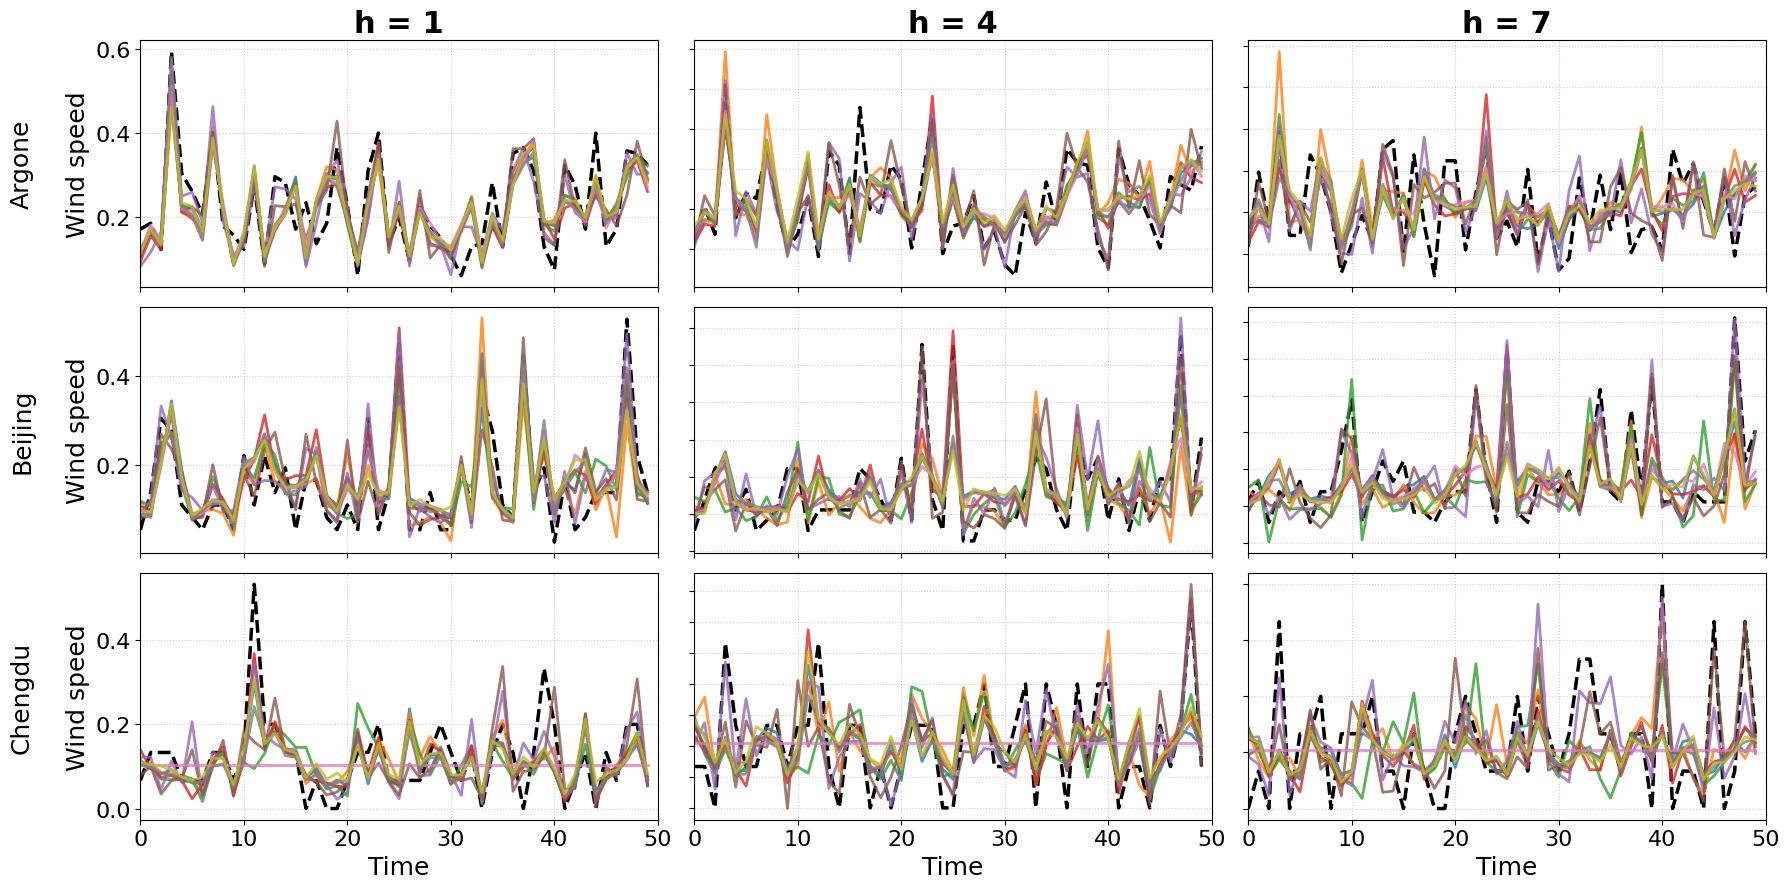

   ✅ Saved: horizon_comparison_group_Hourly.png

🔹 Processing group: Netherland
   Processing: Schiphol
      Models available: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM', 'Transformer', 'Autoformer', 'FEDformer']
      Horizon: 10
   Processing: De Bilt
      Models available: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM', 'Transformer', 'Autoformer', 'FEDformer']
      Horizon: 10
   Processing: Leeuwarden
      Models available: ['RNN', 'GRU', 'LSTM', 'RFF_RNN', 'RFF_GRU', 'RFF_LSTM', 'Transformer', 'Autoformer', 'FEDformer']
      Horizon: 10


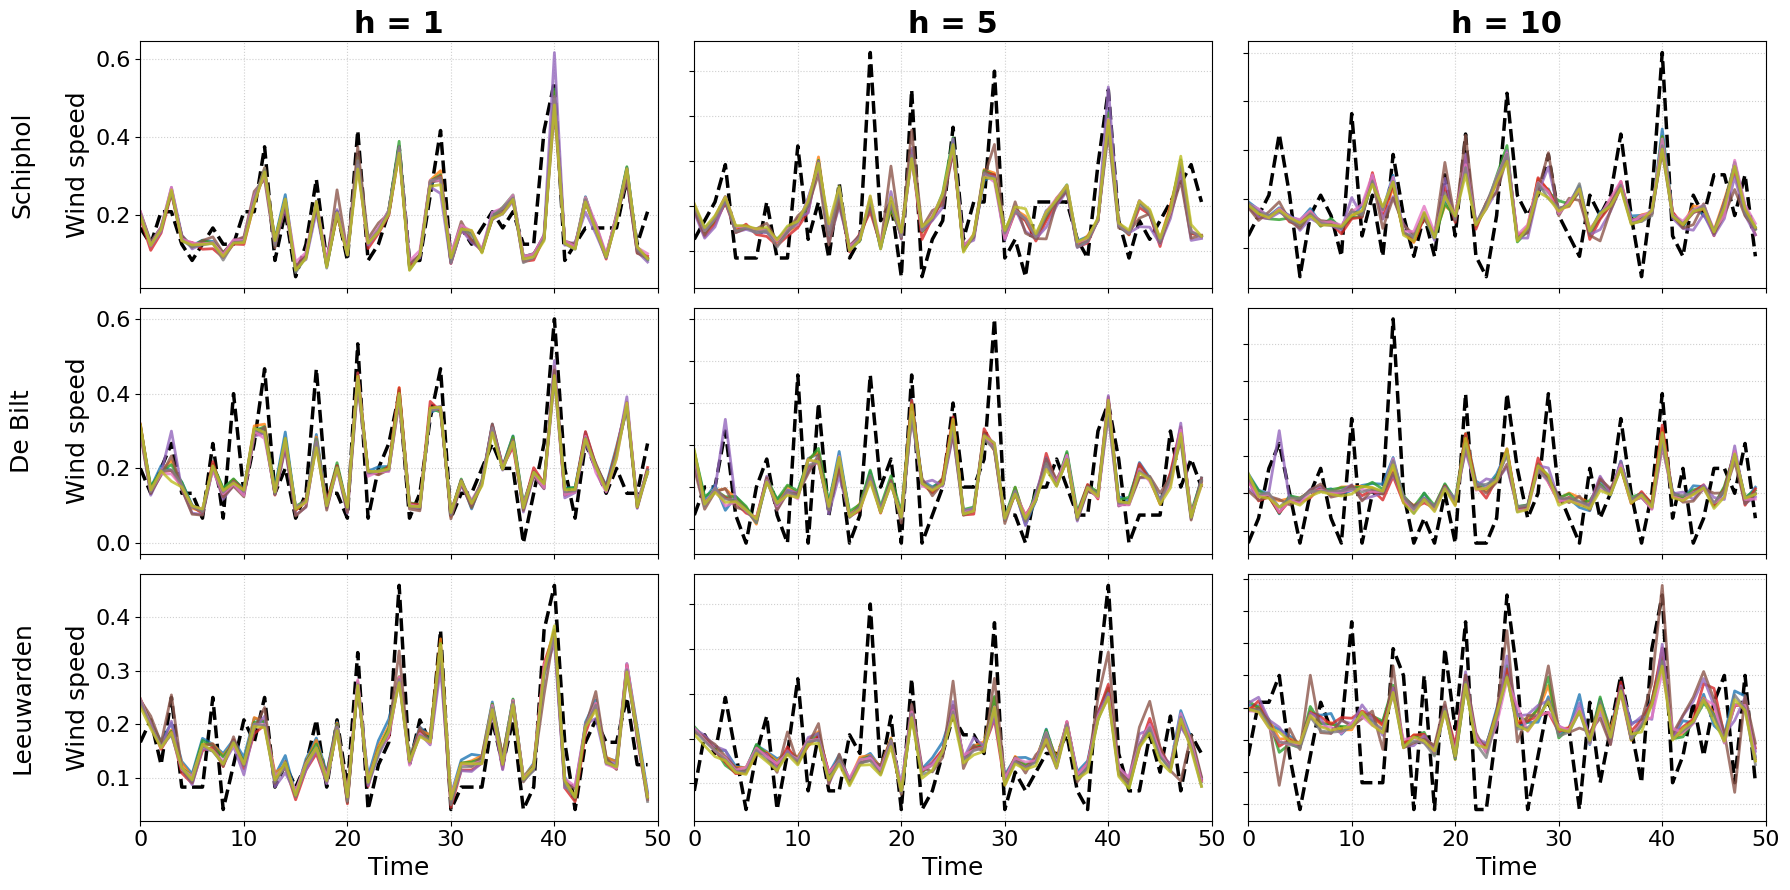

   ✅ Saved: horizon_comparison_group_Netherland.png

✅ All group plots saved to: ../results/plots/horizon_comparison


In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ==========================================
# CONFIGURACIÓN
# ==========================================

METRICS_DIR = Path("../results/metrics")
PLOTS_DIR = Path("../results/plots/horizon_comparison")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Mapeo de nombres
dataset_display_names = {
    "Netherland-0": "Schiphol",
    "Netherland-1": "De Bilt",
    "Netherland-2": "Leeuwarden",
    "Argone": "Argone",
    "Beijing": "Beijing",
    "Chengdu": "Chengdu"
}

# Definir grupos
groups = {
    "Hourly": ["Argone", "Beijing", "Chengdu"],
    "Netherland": ["Netherland-0", "Netherland-1", "Netherland-2"]
}

# ==========================================
# CARGAR TODOS LOS DATOS (RNN + TRANSFORMERS)
# ==========================================

print("\n" + "="*80)
print("📊 LOADING DATA FROM MULTIPLE SOURCES")
print("="*80)

dataset_list = ["Argone", "Beijing", "Chengdu", "Netherland-0", "Netherland-1", "Netherland-2"]
all_data = {}

for dataset_name in dataset_list:
    print(f"\n📄 {dataset_name}")
    
    combined_models = {}
    
    # 1. Cargar archivo RNN/RFF
    file_rnn = METRICS_DIR / f"results_{dataset_name}.pkl"
    if file_rnn.exists():
        try:
            with open(file_rnn, "rb") as f:
                content_rnn = pickle.load(f)
            
            if "models" in content_rnn:
                # Agregar modelos RNN al diccionario combinado
                for model_name, model_data in content_rnn["models"].items():
                    combined_models[model_name] = model_data
                print(f"   ✓ RNN models: {list(content_rnn['models'].keys())}")
        except Exception as e:
            print(f"   ❌ Error loading RNN: {e}")
    
    # 2. Cargar archivo Transformers
    file_trafo = METRICS_DIR / f"results_TRAFO_{dataset_name}.pkl"
    if file_trafo.exists():
        try:
            with open(file_trafo, "rb") as f:
                content_trafo = pickle.load(f)
            
            if "models" in content_trafo:
                # Agregar modelos Transformer al diccionario combinado
                for model_name, model_data in content_trafo["models"].items():
                    combined_models[model_name] = model_data
                print(f"   ✓ Transformer models: {list(content_trafo['models'].keys())}")
        except Exception as e:
            print(f"   ❌ Error loading Transformers: {e}")
    
    # 3. Guardar datos combinados
    if combined_models:
        # Crear estructura similar a la original
        all_data[dataset_name] = {
            "models": combined_models
        }
        print(f"   ✅ Combined: {len(combined_models)} total models")
    else:
        print(f"   ⚠️  No data found for {dataset_name}")

if not all_data:
    print("\n❌ No data loaded!")
    raise SystemExit

# ==========================================
# PROCESAR CADA GRUPO
# ==========================================

print("\n" + "="*80)
print("📊 GENERATING GROUPED HORIZON COMPARISON PLOTS")
print("="*80)

for group_name, dataset_list in groups.items():
    
    print(f"\n🔹 Processing group: {group_name}")
    
    # Filtrar solo los datasets que existen
    existing_datasets = [ds for ds in dataset_list if ds in all_data]
    
    if not existing_datasets:
        print(f"   ⚠️  No data found for group {group_name}")
        continue
    
    n_datasets = len(existing_datasets)
    
    # ==========================================
    # CREAR FIGURA CON SUBPLOTS (n_datasets × 3)
    # ==========================================
    
    fig, axes = plt.subplots(n_datasets, 3, figsize=(18, 3 * n_datasets))
    
    # Asegurar que axes sea 2D
    if n_datasets == 1:
        axes = axes.reshape(1, -1)
    
    # Número de puntos a mostrar
    n_points = 50
    
    for row_idx, dataset_name in enumerate(existing_datasets):
        
        file_content = all_data[dataset_name]
        display_name = dataset_display_names.get(dataset_name, dataset_name)
        
        print(f"   Processing: {display_name}")
        
        # Obtener horizonte H del primer modelo
        first_model = list(file_content["models"].keys())[0]
        H = file_content["models"][first_model]["args"]["horizon"]
        
        print(f"      Models available: {list(file_content['models'].keys())}")
        print(f"      Horizon: {H}")
        
        # Determinar horizontes a plotear
        if H == 7:
            horizons_to_plot = [1, 4, 7]
        elif H == 10:
            horizons_to_plot = [1, 5, 10]
        elif H == 12:
            horizons_to_plot = [1, 6, 12]
        else:
            horizons_to_plot = [1, H // 2, H]
        
        horizon_indices = [h - 1 for h in horizons_to_plot]
        
        # Crear diccionario de pronósticos
        forecast_dict = {}
        for model_name, model_info in file_content["models"].items():
            if "forecast" in model_info:
                forecast_dict[model_name] = (
                    model_info["forecast"]["y_true"],
                    model_info["forecast"]["y_pred"]
                )
        
        if not forecast_dict:
            print(f"      ⚠️  No forecast data found")
            continue
        
        # ==========================================
        # PLOTEAR CADA HORIZONTE (COLUMNAS)
        # ==========================================
        
        for col_idx, (h_idx, h_label) in enumerate(zip(horizon_indices, horizons_to_plot)):
            
            ax = axes[row_idx, col_idx]
            target_plotted = False
            
            for model_name, (y_true_data, y_pred_data) in forecast_dict.items():
                
                # Verificar dimensiones
                if h_idx >= y_pred_data.shape[1]:
                    print(f"      ⚠️  {model_name}: horizon {h_idx} out of range")
                    continue
                
                # Plotear target una sola vez
                if not target_plotted:
                    y_true = y_true_data[0:n_points, h_idx]
                    ax.plot(y_true, label="Target",
                           linestyle='--', color='black', linewidth=2.5)
                    target_plotted = True
                
                # Predicción del modelo
                y_pred = y_pred_data[0:n_points, h_idx]
                model_label = model_name.replace('_', '-')
                ax.plot(y_pred, label=model_label, linewidth=2, alpha=0.8)
            
            # ===== CONFIGURACIÓN DE CADA SUBPLOT =====
            ax.set_xlim(0, n_points)
            
            # Xlabel y valores del eje X solo en la última fila
            if row_idx == n_datasets - 1:
                ax.set_xlabel("Time", fontsize=18)
                ax.tick_params(axis='x', which='major', labelsize=16)
            else:
                ax.set_xticklabels([])  # Ocultar valores del eje X
            
            # Ylabel solo en la primera columna
            if col_idx == 0:
                ax.set_ylabel(f"{display_name}\n\nWind speed", fontsize=18)
                ax.tick_params(axis='y', which='major', labelsize=16)
            else:
                ax.set_yticklabels([])  # Ocultar valores del eje Y
            
            # Título solo en la primera fila
            if row_idx == 0:
                ax.set_title(f"h = {h_label}", fontsize=22, fontweight='bold')
            
            ax.grid(True, linestyle=':', alpha=0.6)
    
    # ===== AJUSTAR ESPACIADO =====
    plt.tight_layout()
    
    # Guardar
    output_path = PLOTS_DIR / f"horizon_comparison_group_{group_name}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"   ✅ Saved: {output_path.name}")

print("\n" + "="*80)
print(f"✅ All group plots saved to: {PLOTS_DIR}")
print("="*80)